## 导入相关的包

In [16]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import lightgbm as lgb
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.preprocessing import LabelEncoder


warnings.filterwarnings('ignore') #忽略警告
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000) #显示所有特征
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 1000)
sns.palplot(sns.color_palette("Blues"))
sns.set_style('whitegrid')
sns.set(font_scale=2)


plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号



## 读取数据

In [17]:
os.chdir('./data')
cust_avli_Q3 = pd.read_csv('x_train/cust_avli_Q3.csv')
cust_avli_Q4 = pd.read_csv('x_train/cust_avli_Q4.csv')
cust_info_Q3 = pd.read_csv('x_train/cust_info_Q3.csv')
cust_info_Q4 = pd.read_csv('x_train/cust_info_Q4.csv')
cust_avli_Q1 = pd.read_csv('x_test/cust_avli_Q1.csv')
cust_info_Q1 = pd.read_csv('x_test/cust_info_Q1.csv')

y_Q3_3 = pd.read_csv('y_train_3/y_Q3_3.csv')
y_Q4_3 = pd.read_csv('y_train_3/y_Q4_3.csv')

### 查看标签的比例

 1    43422
 0    15050
-1    10654
Name: label, dtype: int64
第三季度标签0所占样本的比例： cust_no    0.154124
label      0.154124
dtype: float64
第三季度标签1所占样本的比例： cust_no    0.217718
label      0.217718
dtype: float64
第三季度标签2所占样本的比例： cust_no    0.628157
label      0.628157
dtype: float64
 1    49396
 0    15187
-1    11587
Name: label, dtype: int64
第四季度标签0所占样本的比例： cust_no    0.15212
label      0.15212
dtype: float64
第四季度标签1所占样本的比例： cust_no    0.199383
label      0.199383
dtype: float64
第四季度标签2所占样本的比例： cust_no    0.648497
label      0.648497
dtype: float64


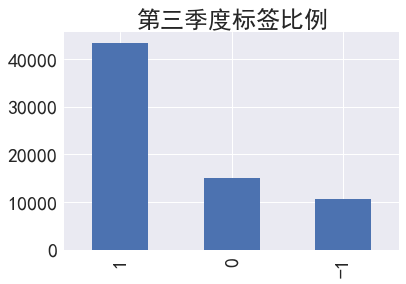

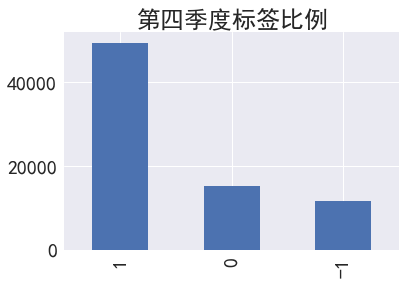

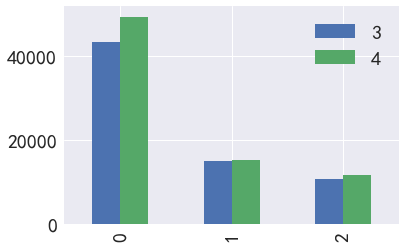

In [18]:
labels=y_Q3_3['label'].value_counts()
print(labels)
print("第三季度标签0所占样本的比例：",y_Q3_3.loc[y_Q3_3['label']==-1].count()/len(y_Q3_3))
print('第三季度标签1所占样本的比例：',y_Q3_3.loc[y_Q3_3['label']==0].count()/len(y_Q3_3))
print('第三季度标签2所占样本的比例：',y_Q3_3.loc[y_Q3_3['label']==1].count()/len(y_Q3_3))
plt.figure()
labels.plot.bar()
plt.title('第三季度标签比例')

labels=y_Q4_3['label'].value_counts()
print(labels)
print("第四季度标签0所占样本的比例：",y_Q4_3.loc[y_Q4_3['label']==-1].count()/len(y_Q4_3))
print('第四季度标签1所占样本的比例：',y_Q4_3.loc[y_Q4_3['label']==0].count()/len(y_Q4_3))
print('第四季度标签2所占样本的比例：',y_Q4_3.loc[y_Q4_3['label']==1].count()/len(y_Q4_3))
plt.figure()
labels.plot.bar()
plt.title('第四季度标签比例')

df = pd.DataFrame(np.vstack([y_Q3_3['label'].value_counts().values, y_Q4_3['label'].value_counts().values]).T, columns=list('34'))
# 绘制图形
df.plot(kind='bar')

## 有效用户的分析
- 对于用户, cust_avli_Q4和y_Q4_3可以完全一致, 同样cust_avli_Q3和y_Q3_3可以完全一致

- 有58090个用户这三个月 都有

In [5]:
print(cust_avli_Q3.merge(y_Q3_3, how='outer', indicator=True, on='cust_no')['_merge'].value_counts())
print(cust_avli_Q4.merge(y_Q4_3, how='outer', indicator=True, on='cust_no')['_merge'].value_counts())

both          69126
right_only        0
left_only         0
Name: _merge, dtype: int64
both          76170
right_only        0
left_only         0
Name: _merge, dtype: int64


- 有效用户变化情况分析

In [12]:
print('三、四月份增加和减少\n',cust_avli_Q4.merge(cust_avli_Q3, how='outer', indicator=True, on='cust_no')['_merge'].value_counts())
print('四、五月份增加和减少\n',cust_avli_Q1.merge(cust_avli_Q4, how='outer', indicator=True, on='cust_no')['_merge'].value_counts())
print('三、五月份增加和减少\n',cust_avli_Q1.merge(cust_avli_Q3, how='outer', indicator=True, on='cust_no')['_merge'].value_counts())

三、四月份
 both          62397
left_only     13773
right_only     6729
Name: _merge, dtype: int64
四、五月份
 both          69441
left_only      7281
right_only     6729
Name: _merge, dtype: int64
三、五月份
 both          58921
left_only     17801
right_only    10205
Name: _merge, dtype: int64


- 通过分析开户时间，可以发现相比于上一个季度，大部分新增加的有效用户是当季度新注册用户

In [143]:
tmp = cust_avli_Q4.merge(cust_avli_Q3, how='outer', indicator=True, on='cust_no')
new_custno_4 = pd.DataFrame(tmp.loc[tmp['_merge']=='left_only', 'cust_no'])
tmp = new_custno_4.merge(event[['cust_no', 'E1', 'E2']], how='inner', on='cust_no')
tmp

,cust_no,E1,E2
0,0xb2da4f54,2019-12-23,2019-12-23
1,0xb2da4f54,2019-12-23,2019-12-23
2,0xb2da4c96,2019-12-20,2019-12-20
3,0xb2da4c96,2019-12-20,2019-12-20
4,0xb2d9d0dc,2019-11-07,2019-11-07
...,...,...,...
34182,0xb2d9d7ab,2019-11-11,2019-11-11
34183,0xb2da518a,2019-12-23,2019-12-23
34184,0xb2da518a,2019-12-23,2019-12-23
34185,0xb2d9ed26,2019-11-19,2019-11-19


In [163]:
tmp[tmp['E1'].isnull()&tmp['E2'].isnull()]# 对于有效用户，几乎不可能E1都为空和E2都为空

### 分析新出现的有效用户
tmp = cust_avli_Q4.merge(cust_avli_Q3, how='outer', indicator=True, on='cust_no')
new_custno_4 = pd.DataFrame(tmp.loc[tmp['_merge']=='left_only', 'cust_no'])
tmp = new_custno_4.merge(event.loc[event['season']==4], how='inner', on='cust_no')

f = 'E1'
print('当季度注册用户数', tmp[(((pd.to_datetime('2020-01-01 00:00:00') - pd.to_datetime(tmp[f])).dt.days)<=90)]['cust_no'].nunique())
print('上个季度注册用户数', tmp[(((pd.to_datetime('2020-01-01 00:00:00') - pd.to_datetime(tmp[f])).dt.days)>90)&(((pd.to_datetime('2020-01-01 00:00:00') - pd.to_datetime(tmp[f])).dt.days)<=180)]['cust_no'].nunique())
print('上上个季度注册用户数', tmp[(((pd.to_datetime('2020-01-01 00:00:00') - pd.to_datetime(tmp[f])).dt.days)>180)&(((pd.to_datetime('2020-01-01 00:00:00') - pd.to_datetime(tmp[f])).dt.days)<=270)]['cust_no'].nunique())
print('上上上个季度注册用户数', tmp[(((pd.to_datetime('2020-01-01 00:00:00') - pd.to_datetime(tmp[f])).dt.days)>270)&(((pd.to_datetime('2020-01-01 00:00:00') - pd.to_datetime(tmp[f])).dt.days)<=360)]['cust_no'].nunique())
print('上上个季度前注册用户数', tmp[(((pd.to_datetime('2020-01-01 00:00:00') - pd.to_datetime(tmp[f])).dt.days)>360)]['cust_no'].nunique())

当季度注册用户数 7324
上个季度注册用户数 2635
上上个季度注册用户数 731
上上上个季度注册用户数 424
上上个季度前注册用户数 2659


In [ ]:
train = y_Q4_3.copy()
y_Q3_3 = y_Q3_3.rename(columns={'label': 'bef_label'})
train = train.merge(y_Q3_3, on=['cust_no'], how='left').copy()

test = cust_avli_Q1.copy()
y_Q4_3 = y_Q4_3.rename(columns={'label': 'bef_label'})
test = test.merge(y_Q4_3, on=['cust_no'], how='left')

## 重大事件EDA
- 异常值
对于E1，E8 存在异常值.对于E8只在season =5 中存在，有15个用户

这些异常值是真异常还是特殊意义？异常值共有1899-12-31， 1900-01-01这两个

- 缺失值分析

一般来说，开户日一般有，电子开户日可能没有
E11全为空

- 其他

E2和E3完全一样，保留一个即可

事件的缺失多的，最多是E6和E9,缺失率高达%95

E9逾期的话，相对信用会低

  

  



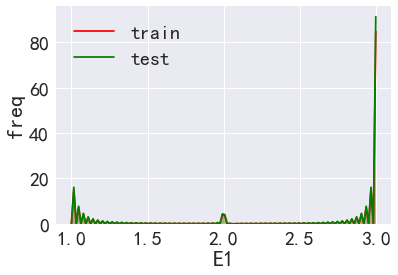

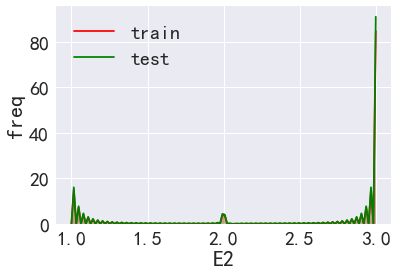

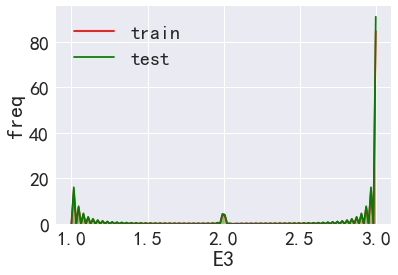

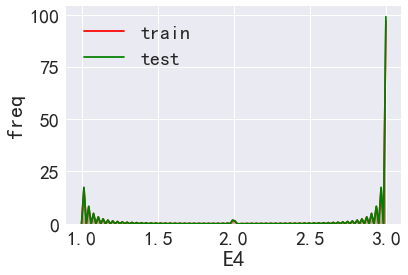

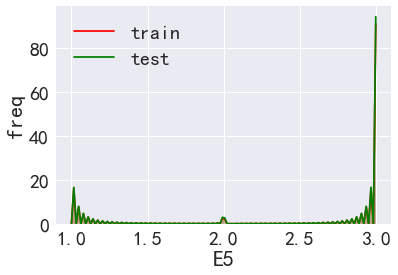

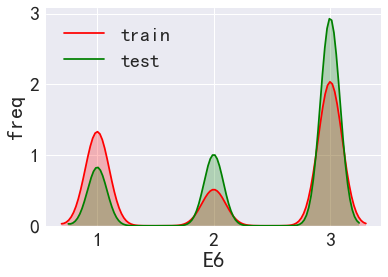

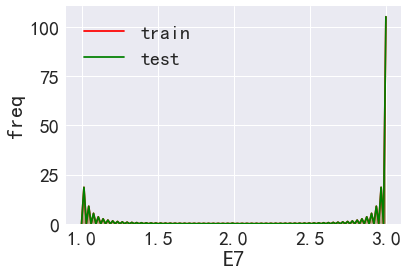

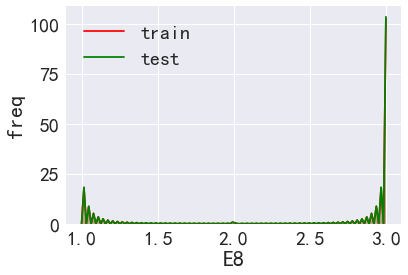

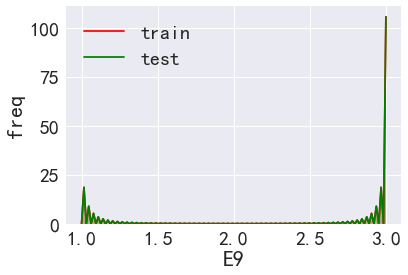

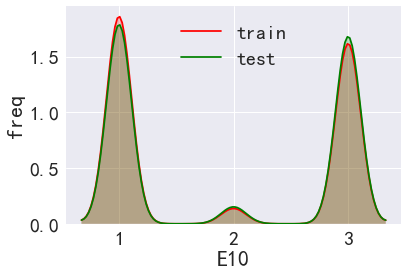

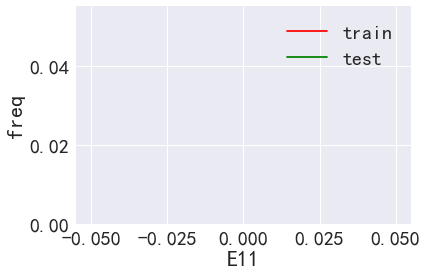

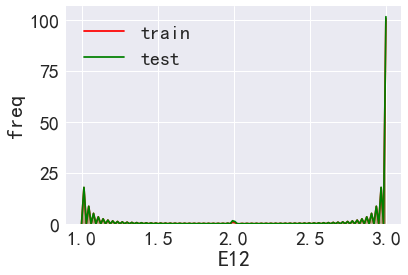

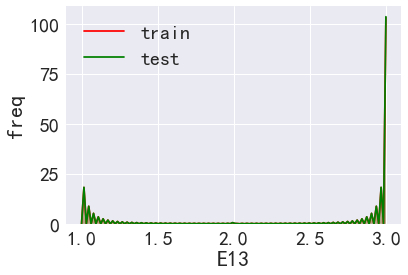

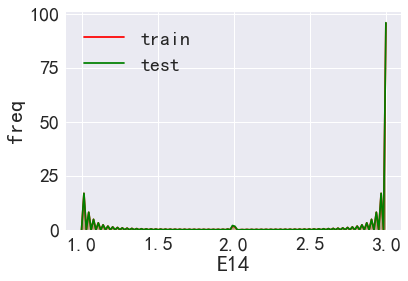

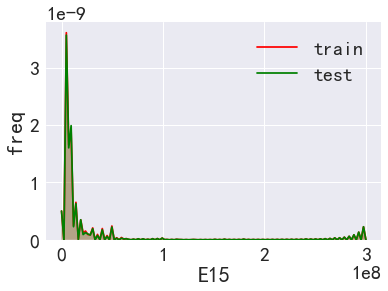

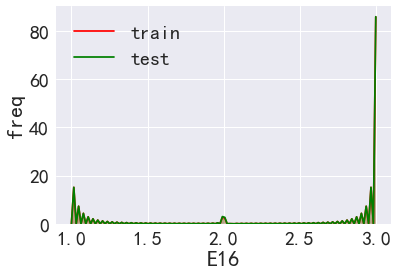

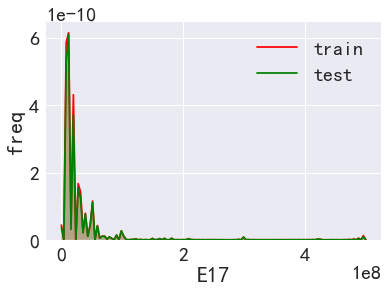

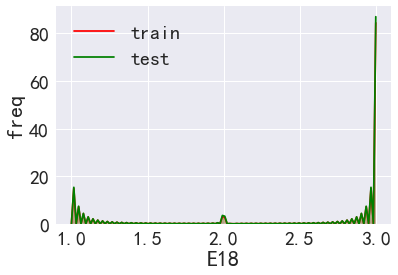

In [21]:
import pandas as pd
event = pd.read_csv('event.csv')
E_cols = [f for f in event.columns if f.startswith('E')]
for col in E_cols:
    if col not in [ 'E15', 'E17']:
        event[col] = (pd.to_datetime('2020-04-01 00:00:00') - pd.to_datetime(event[col])).dt.days
event['event_num'] = len(E_cols) - event[E_cols].isnull().sum(axis=1)

tmp = event[event['season']==4].copy()
del tmp['season']
for col in E_cols:
    if col not in [ 'E15', 'E17']:
        tmp[col] = tmp[col] - 90
train = train.merge(tmp, on=['cust_no'], how='left')

tmp = event[event['season']==5].copy()
del tmp['season']
test = test.merge(tmp, on=['cust_no'], how='left')

def get_event_fea(x):   
    if x<90:
        return 1  
    elif x<180:
        return 2  
    return 3  

for col in E_cols:
    if col not in [ 'E15', 'E17']:
        train[col] = train[col].apply(lambda x: get_event_fea(x))
        test[col] = test[col].apply(lambda x: get_event_fea(x))

# 分箱后分布可视化
for col in E_cols:
    g = sns.kdeplot(train[col], color="Red", shade = True)
    g = sns.kdeplot(test[col], ax =g, color="Green", shade = True)
    g.set_xlabel(col)
    g.set_ylabel("freq")
    g = g.legend(["train","test"])
    plt.show()

In [ ]:
# E1和E2很大概率一样
(event['E1']==event['E2']).sum(axis=0)/len(event)
# event[(event['E1'].isnull())&(event['E2'].notnull())]
event[(event['E2'].isnull())&(event['E1'].notnull())]

In [ ]:
# event_fils = os.listdir('x_train/big_event_train/')+os.listdir('x_test/big_event_test/')
# event = []
# for f in event_fils:
#     print(f)
#     season = int((f.split('.')[0]).split('_')[-1].replace('Q', ''))
#     if season>=3:
#         tmp = pd.read_csv('x_train/big_event_train/'+f)
#         tmp['season'] = season
#     else:
#         tmp = pd.read_csv('x_test/big_event_test/'+f)
#         tmp['season'] = season + 4
    
#     event.append(tmp)
# event = pd.concat(event, axis=0, ignore_index=True)

### 减少内存
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                c_prec = df[col].apply(lambda x: np.finfo(x).precision).max()
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max and c_prec == np.finfo(np.float16).precision:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max and c_prec == np.finfo(np.float32).precision:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# event = reduce_mem_usage(event)
# event.to_csv('event.csv', index=False)
import pandas as pd
event = pd.read_csv('./data/event.csv')
del event['E3']
del event['E11']
event.head()

In [8]:
# 缺失值统计
print(event.isnull().sum() / len(event))

cust_no    0.000000
E1         0.000017
E2         0.408660
E3         0.408660
E4         0.902738
E5         0.749899
E6         0.671930
E7         0.995268
E8         0.930072
E9         0.996435
E10        0.611257
E11        1.000000
E12        0.934218
E13        0.961892
E14        0.849890
E15        0.000000
E16        0.834413
E17        0.000000
E18        0.824670
season     0.000000
dtype: float64


### 第二期特征工程
- 对日期进行分箱，增加数值稳定性

In [23]:
import pandas as pd
event = pd.read_csv('event.csv')
cust_avli_Q4 = pd.read_csv('x_train/cust_info_Q4.csv')
cust_avli_Q1 = pd.read_csv('x_test/cust_avli_Q1.csv')
del event['E3'], event['E11']

## 现将异常值替换成nan
event.loc[pd.to_datetime(event['E1'])<pd.to_datetime('1949-10-01 00:00:00'), 'E1']= np.nan
event.loc[pd.to_datetime(event['E8'])<pd.to_datetime('1949-10-01 00:00:00'), 'E8']= np.nan

## 用E2填充E1
# event.loc[event['E1'].isnull()&event['E2'].notnull(), 'E1'] = event.loc[event['E1'].isnull()&event['E2'].notnull(), 'E2']
event.loc[event['E2'].isnull()&event['E1'].notnull(), 'E2'] = event.loc[event['E2'].isnull()&event['E1'].notnull(), 'E1']

## 现转换成时间数据格式
E_cols = [f for f in event.columns if f.startswith('E')]
for col in E_cols:
    if col not in [ 'E15', 'E17']:
        event[col] = pd.to_datetime(event[col])
        
def get_Dateencoder(x, flag):
    if flag==1:
        #  当季度   
        if x > pd.to_datetime('2019-10-01 00:00:00'): return 1
         #  上一季度  
        elif  x > pd.to_datetime('2019-07-01 00:00:00'): return 2
         #  上上季度  
        elif  x > pd.to_datetime('2019-04-01 00:00:00'): return 3
        #  上上上季度 
        elif  x > pd.to_datetime('2019-01-01 00:00:00'): return 4
        #  长期
        return 5
    elif flag==0:
        #  当季度  
        if x > pd.to_datetime('2020-01-01 00:00:00'): return 1    
        #  上一季度  
        elif x > pd.to_datetime('2019-10-01 00:00:00'): return 2
         #  上上季度  
        elif  x > pd.to_datetime('2019-07-01 00:00:00'): return 3
        #  上上上季度   
        elif  x > pd.to_datetime('2019-04-01 00:00:00'): return 4
        #  长期
        return 5
    
train = pd.DataFrame(cust_avli_Q4['cust_no'])
train = train.merge(event.loc[event['season']==4], how='inner', on='cust_no')
del train['season']

test = pd.DataFrame(cust_avli_Q1['cust_no'])
test = test.merge(event.loc[event['season']==5], how='inner', on='cust_no')
del test['season']


E_cols = [f for f in event.columns if f.startswith('E')]
for col in E_cols:
    if col not in [ 'E15', 'E17']:
        print(col)
        train[col] = train[col].apply(lambda x: get_Dateencoder(x, 1))
        test[col] = test[col].apply(lambda x: get_Dateencoder(x, 0))        
        
train['flag'] = 1
test['flag'] = 0
event_feat_engineering2 = pd.concat([train, test], axis=0, ignore_index=True)

# 超过一定时期可以截断
# train.loc[train['E16']>2, 'E15'] = 0
# train.loc[train['E18']>2, 'E17'] = 0

# test.loc[test['E16']>2, 'E15'] = 0
# test.loc[test['E18']>2, 'E17'] = 0
# event_feat_engineering2.to_pickle('event_feat_engineering2.pkl')




E1
E2


KeyboardInterrupt: 

### 第一期特征工程
转化为连续特征

In [107]:
train = pd.DataFrame(cust_avli_Q4['cust_no'])
train = train.merge(event.loc[event['season']==4], how='inner', on='cust_no')
train.head()
del train['season']

test = pd.DataFrame(cust_avli_Q1['cust_no'])
test = test.merge(event.loc[event['season']==5], how='inner', on='cust_no')
del test['season']
test.head()


,cust_no,E1,E2,E4,E5,E6,E7,E8,E9,E10,E12,E13,E14,E15,E16,E17,E18
0,0x3b9b4615,2014-07-04,2015-03-30,2019-02-21,2015-05-04,2019-04-23,NaN,NaN,NaN,2014-12-03,2014-10-17,2019-02-21,2015-05-04,1170000.00,2017-01-25,2315000.0,2016-05-20
1,0x3b9ae61b,2015-03-28,2015-03-28,2015-07-08,2015-03-28,2014-09-21,NaN,NaN,NaN,2014-08-09,2014-09-28,2015-07-08,2015-03-28,5219392.44,2015-01-15,5000000.0,2014-09-29
2,0x3b9add69,2006-11-22,2015-09-09,NaN,NaN,2016-03-16,NaN,NaN,NaN,2014-08-19,NaN,NaN,NaN,0.00,NaN,0.0,NaN
3,0x3b9b3601,2014-04-17,2016-10-14,2016-10-14,2017-06-19,2018-04-19,NaN,NaN,NaN,2017-06-12,NaN,NaN,2020-01-18,298000.00,2018-07-31,307747.0,2016-10-17
4,0x3b9b2599,2013-09-03,2018-05-07,2018-05-10,NaN,2015-09-23,NaN,NaN,NaN,2015-11-01,NaN,NaN,NaN,1700000.00,2018-12-17,1000000.0,2015-09-29


In [119]:
def get_Feat(train, test, E_cols):
    for col in E_cols:
        train[col] = (pd.to_datetime('2020-01-01 00:00:00') - pd.to_datetime(train[col])).dt.days 
#         train[col] =  (pd.to_datetime(train[col]).dt.days/30)
        test[col] = (pd.to_datetime('2020-04-01 00:00:00') - pd.to_datetime(test[col])).dt.days 
#         test[col] =  (pd.to_datetime(test[col]).dt.days/30)
    return train, test
E_cols = [f for f in event.columns if f.startswith('E') and f not in [ 'E15', 'E17']]
train, test = get_Feat(train, test, E_cols)
# 超过一定时期可以截断
train.loc[train['E16']>180, 'E15'] = 0
train.loc[train['E18']>180, 'E17'] = 0
test.loc[test['E16']>180, 'E15'] = 0
test.loc[test['E18']>180, 'E17'] = 0

In [124]:
train['flag'] = 1
test['flag'] = 0
event_feat_engineering1 = pd.concat([train, test], axis=0, ignore_index=True)
event_feat_engineering1.to_pickle('event_feat_engineering1.pkl')
event_feat_engineering1.head()

,cust_no,E1,E2,E4,E5,E6,E7,E8,E9,E10,E12,E13,E14,E15,E16,E17,E18,flag
0,0xb2d8e1f9,168.0,168.0,168.0,NaN,70.0,NaN,NaN,NaN,71.0,NaN,NaN,NaN,1300.0,69.0,0.0,NaN,1
1,0xb2da4f54,9.0,9.0,NaN,9.0,9.0,NaN,NaN,NaN,8.0,NaN,NaN,NaN,0.0,NaN,0.0,NaN,1
2,0xb2d0f4e5,1567.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1325.0,NaN,NaN,NaN,0.0,NaN,0.0,NaN,1
3,0x3b9b3b70,2049.0,1724.0,1724.0,1577.0,520.0,NaN,NaN,NaN,1457.0,NaN,1724.0,1566.0,0.0,1297.0,0.0,541.0,1
4,0xb2d8d086,177.0,177.0,177.0,173.0,164.0,NaN,NaN,NaN,125.0,NaN,NaN,NaN,0.0,NaN,300000.0,163.0,1


## 存款信息EDA

### 加载数据

In [53]:
cunkuan_fils = os.listdir('x_train/cunkuan_train/')+os.listdir('x_test/cunkuan_test/')
cunkuan = []
for f in cunkuan_fils:
    print(f)
    mon = int((f.split('.')[0]).split('_')[-1].replace('m', ''))
    if mon>=7:
        tmp = pd.read_csv('x_train/cunkuan_train/'+f)
        tmp['mon'] = mon
    else:
        tmp = pd.read_csv('x_test/cunkuan_test/'+f)
        tmp['mon'] = mon+12
    cunkuan.append(tmp)
cunkuan = pd.concat(cunkuan, axis=0, ignore_index=True)

cunkuan_m10.csv
cunkuan_m11.csv
cunkuan_m12.csv
cunkuan_m7.csv
cunkuan_m8.csv
cunkuan_m9.csv
cunkuan_m1.csv
cunkuan_m2.csv
cunkuan_m3.csv


### 缺失值统计

In [54]:
print(cunkuan.isnull().sum() / len(cunkuan))
cunkuan.head()

cust_no    0.0
C1         0.0
C2         0.0
mon        0.0
dtype: float64


,cust_no,C1,C2,mon
0,0xb2d3ad96,231097.73,6,10
1,0xb2d40f1c,5.34,1,10
2,0xb2d6bb22,13808.58,1,10
3,0xb2d6bb1f,42322.89,2,10
4,0xb2d3d20b,140007.62,3,10


### 资产数据EDA

加载数据

In [49]:
aum_fils = os.listdir('x_train/aum_train/')+os.listdir('x_test/aum_test/')
aum = []
for f in aum_fils:
    print(f)
    mon = int((f.split('.')[0]).split('_')[-1].replace('m', ''))
    if mon>=7:
        tmp = pd.read_csv('x_train/aum_train/'+f)
        tmp['mon'] = mon
    else:
        tmp = pd.read_csv('x_test/aum_test/'+f)
        tmp['mon'] = mon+12
    aum.append(tmp)
aum = pd.concat(aum, axis=0, ignore_index=True)

aum_m10.csv
aum_m11.csv
aum_m12.csv
aum_m7.csv
aum_m8.csv
aum_m9.csv
aum_m1.csv
aum_m2.csv
aum_m3.csv


 缺失值统计

In [51]:
print(aum.isnull().sum() / len(aum))

cust_no    0.0
X1         0.0
X2         0.0
X3         0.0
X4         0.0
X5         0.0
X6         0.0
X7         0.0
X8         0.0
mon        0.0
dtype: float64


In [13]:
# 提取季度间波动特征
def get_Feature(df_fea, train, test, f):
#     f = 'X3'
    df_fea = df_fea[~df_fea['cust_no'].isnull()] #去除id为空的行
    stat = pd.DataFrame(df_fea[['cust_no']].drop_duplicates())#去除重复值
    for i in range(7,16):
        tmp = df_fea[(df_fea['mon']==i)][['cust_no', f]].copy()
        stat = stat.merge(tmp, on=['cust_no'], how='left')
        print(stat.shape)
#     stat.fillna(value=0, inplace=True)
    stat.columns =['cust_no'] + [f + '_' + str(i) for i in range(7, 16)]
    # 季度内波动
    stat[f+'_3s'] = stat[f +'_9'] - stat[f +'_7']
    stat[f+'_4s'] = stat[f +'_12'] - stat[f +'_10']
    stat[f+'_5s'] = stat[f +'_15'] - stat[f +'_13']
    # 季度间波动
    stat[f+'_34s'] = stat[f +'_12'] - stat[f +'_9']
    stat[f+'_45s'] = stat[f +'_15'] - stat[f +'_12']


    tmp = stat[['cust_no', f+'_9', f+'_12', f+'_3s', f+'_4s', f+'_34s']].copy()
    tmp.columns = ['cust_no'] + [f+'_'+str(i) for i in range(1,6)]
    train = train.merge(tmp, on=['cust_no'], how='left')
    del tmp

    tmp = stat[['cust_no',f+'_12', f+'_15', f+'_4s', f+'_5s',f+'_45s']].copy()
    tmp.columns = ['cust_no'] + [f+'_'+str(i) for i in range(1,6)]
    test = test.merge(tmp, on=['cust_no'], how='left')
    del tmp
    return train, test
train, test =  get_Feature(aum, train, test, 'X3')
train

,cust_no,label,bef_label,I1,I2,I3_x,I4,I5,I6,I7,I8,I9,I10,I11,I12,I13,I14,I15,I16,I17,I18,I19,I20,I3_y,X3_1,X3_2,X3_3,X3_4,X3_5
0,0xb2d8e1f9,1,1.0,男性,66,黄金,0.0,办事人员和有关人员,0,0,双子座,NaN,NaN,0.0,个人,NaN,NaN,0,1.0,1,1,1,0,普通客户,2.53,86.19,2.53,7.66,83.66
1,0xb2da4f54,1,NaN,女性,49,普通客户,0.0,不便分类的其他从业人员,0,0,双鱼座,NaN,NaN,0.0,个人,NaN,NaN,0,0.0,1,1,1,0,NaN,NaN,8.00,NaN,NaN,NaN
2,0xb2d0f4e5,1,1.0,女性,70,普通客户,0.0,服务性工作人员,0,0,摩羯座,NaN,NaN,0.0,个人,NaN,NaN,0,0.0,0,0,1,0,普通客户,1015.57,1016.55,0.99,0.98,0.98
3,0x3b9b3b70,1,1.0,男性,65,黄金,0.0,NaN,0,0,白羊座,NaN,NaN,0.0,个人,NaN,NaN,0,1.0,1,1,1,1,黄金,217.66,259924.24,-176155.27,259706.58,259706.58
4,0xb2d8d086,1,1.0,男性,34,钻石,0.0,商业工作人员,0,0,白羊座,NaN,NaN,0.0,个人,NaN,NaN,0,1.0,1,1,1,0,钻石,748.01,726.30,748.01,563.10,-21.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76165,0xb2d174f1,1,-1.0,女性,38,白金,0.0,商业工作人员,0,0,天蝎座,NaN,NaN,0.0,个人,NaN,NaN,0,1.0,1,1,1,0,普通客户,3343.33,3346.26,3343.33,2.93,2.93
76166,0x3b9af14f,0,0.0,男性,31,白金,1.0,不便分类的其他从业人员,0,0,天蝎座,NaN,NaN,0.0,个人,NaN,NaN,0,1.0,1,1,0,1,白金,111094.58,50082.42,3755.63,-685801.74,-61012.16
76167,0xb2d1bb5d,0,1.0,男性,29,黄金,1.0,商业工作人员,0,0,处女座,NaN,NaN,0.0,个人,NaN,NaN,0,1.0,1,1,1,1,黄金,1174.34,9651.47,-10084.39,-6049.99,8477.13
76168,0xb2d9ed26,1,NaN,女性,28,普通客户,0.0,专业技术人员,0,0,金牛座,NaN,NaN,0.0,个人,NaN,NaN,0,0.0,1,1,1,1,NaN,NaN,7347.46,NaN,NaN,NaN


## 用户属性EDA
    I4本行员工数也可以基本忽略, I7本行持有产品数全为0，I8星座感觉都一样，I9客户贡献度全为nan肯定不用, I15, I17= I18, I19, I20二维码收单客户标志感觉基本没用

### 训练集和测试集分布差异统计

In [11]:
for i in cust_info_Q4.columns:
    trn_ = set(cust_info_Q3[i].unique())
    tst_ = set(cust_info_Q4[i].unique())
    print(i, len(trn_), len(tst_), 1.0*len(trn_&tst_)/len(tst_))

cust_no 493441 543823 0.9073558860143833
I1 3 3 1.0
I2 113 114 0.9736842105263158
I3 5 5 1.0
I4 3 3 0.6666666666666666
I5 23 23 1.0
I6 2 2 1.0
I7 1 1 1.0
I8 13 13 1.0
I9 1 1 0.0
I10 11 11 1.0
I11 1649 1799 0.9027237354085603
I12 11 11 1.0
I13 7 7 1.0
I14 7 7 1.0
I15 2 2 1.0
I16 3 3 0.6666666666666666
I17 2 2 1.0
I18 2 2 1.0
I19 2 2 1.0
I20 2 2 1.0


In [129]:
train = y_Q4_3.copy()
train = train.merge(cust_info_Q4, on=['cust_no'], how='left')

I1:本行员工标志

Text(0.5,1,'Distribution Of I1 In Train')

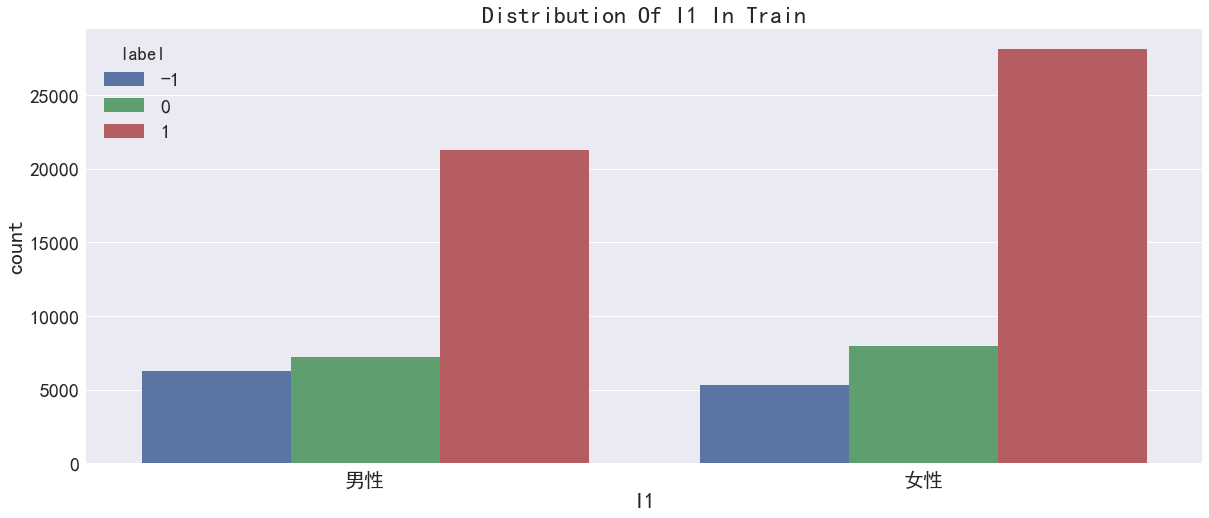

In [131]:
plt.figure(figsize=(20, 8))
plt.subplot(1,1,1)
sns.countplot(x='I1', hue='label', data=train)
plt.title('Distribution Of I1 In Train')

I2: 性别

Text(0.5,1,'Distribution Of I2 In Train')

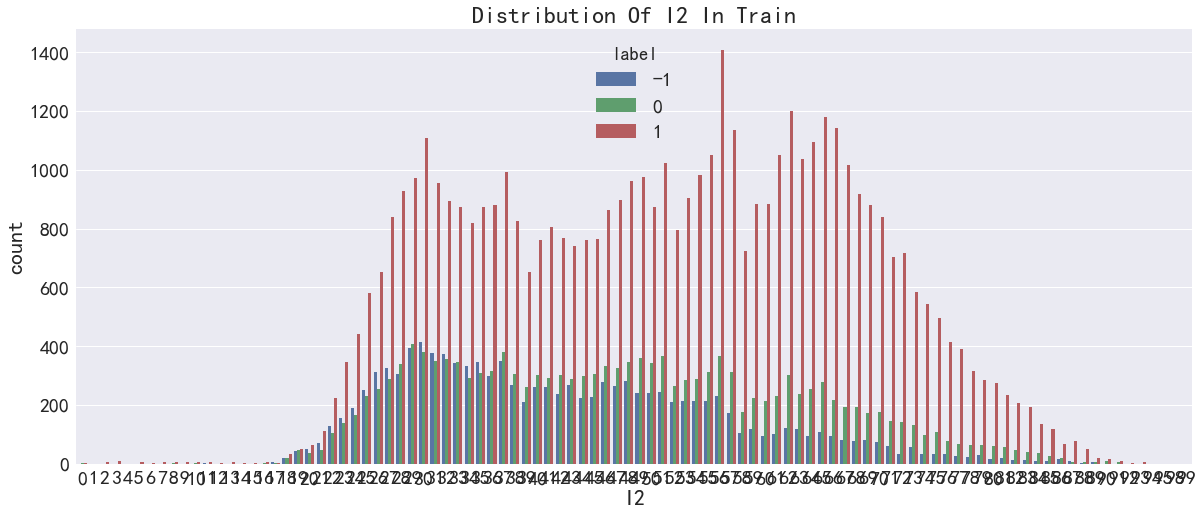

In [132]:
plt.figure(figsize=(20, 8))
plt.subplot(1,1,1)
sns.countplot(x='I2', hue='label', data=train)
plt.title('Distribution Of I2 In Train')


I3: 客户等级

Text(0.5,1,'Distribution Of I3 In Train')

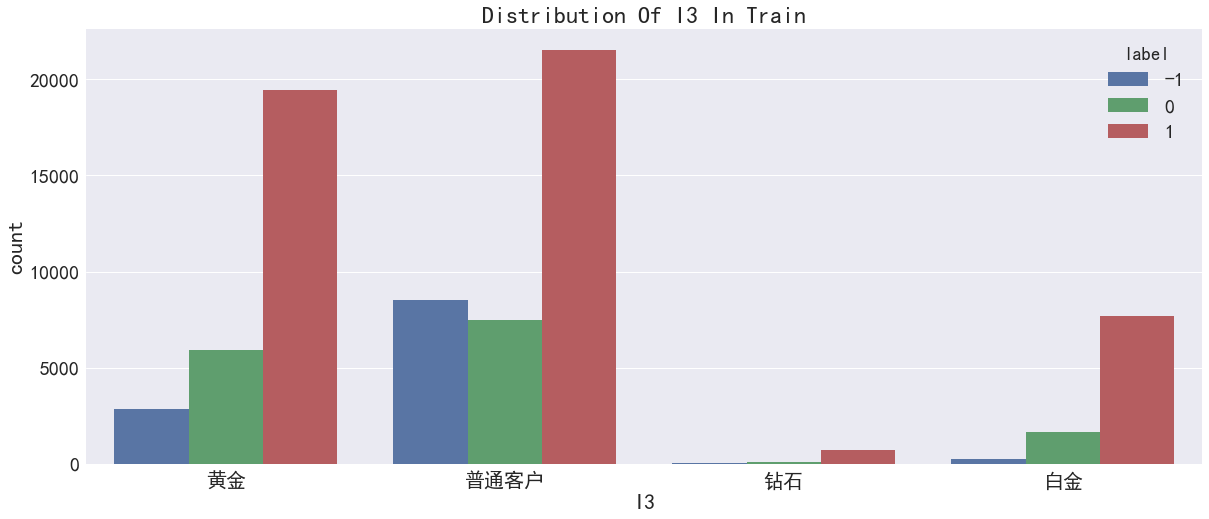

In [133]:
plt.figure(figsize=(20, 8))
plt.subplot(1,1,1)
sns.countplot(x='I3', hue='label', data=train)
plt.title('Distribution Of I3 In Train')


I4 本行员工标志

Text(0.5,1,'Distribution Of I4 In Train')

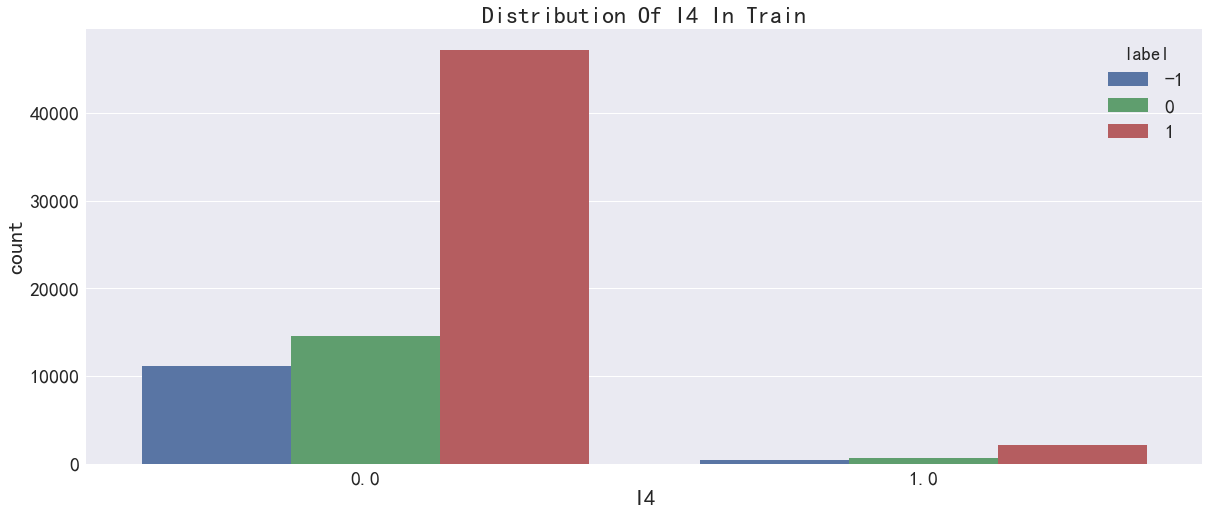

In [135]:
plt.figure(figsize=(20, 8))
plt.subplot(1,1,1)
sns.countplot(x='I4', hue='label', data=train)
plt.title('Distribution Of I4 In Train')


I5 职业描述

Text(0.5,1,'Distribution Of I5 In Train')

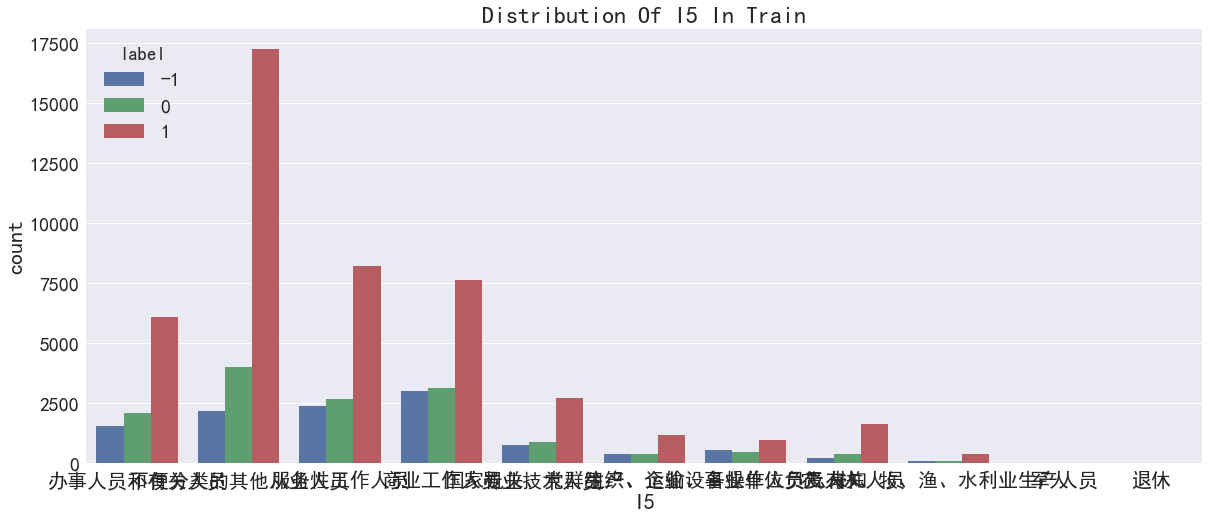

In [136]:
plt.figure(figsize=(20, 8))
plt.subplot(1,1,1)
sns.countplot(x='I5', hue='label', data=train)
plt.title('Distribution Of I5 In Train')


I6我行贷款客户标志


Text(0.5,1,'Distribution Of I3 In Train')

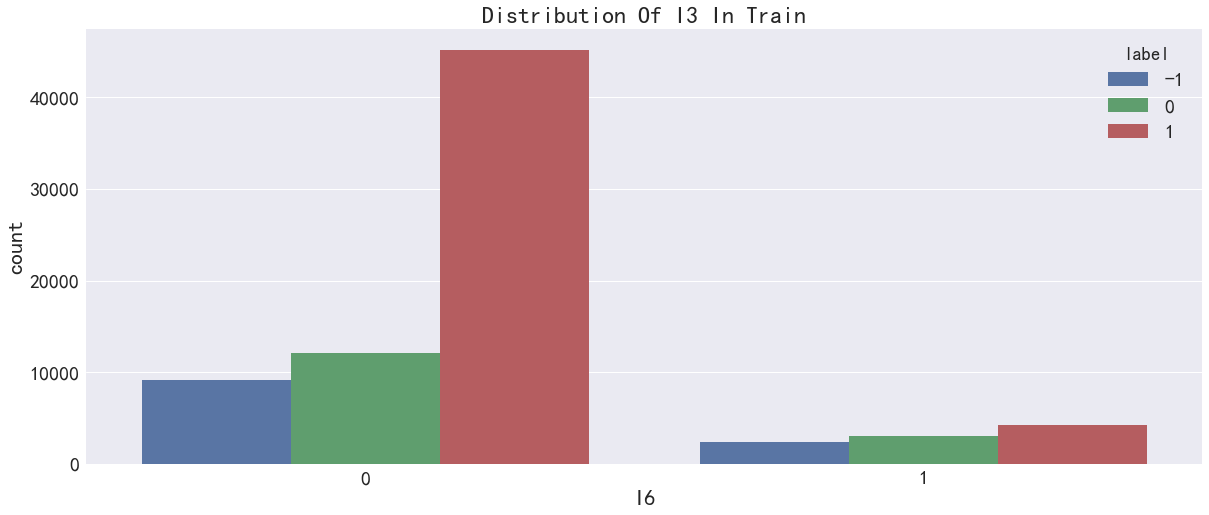

In [137]:
plt.figure(figsize=(20, 8))
plt.subplot(1,1,1)
sns.countplot(x='I6', hue='label', data=train)
plt.title('Distribution Of I3 In Train')


I7 本行产品持有数, 全是0

Text(0.5,1,'Distribution Of I7 In Train')

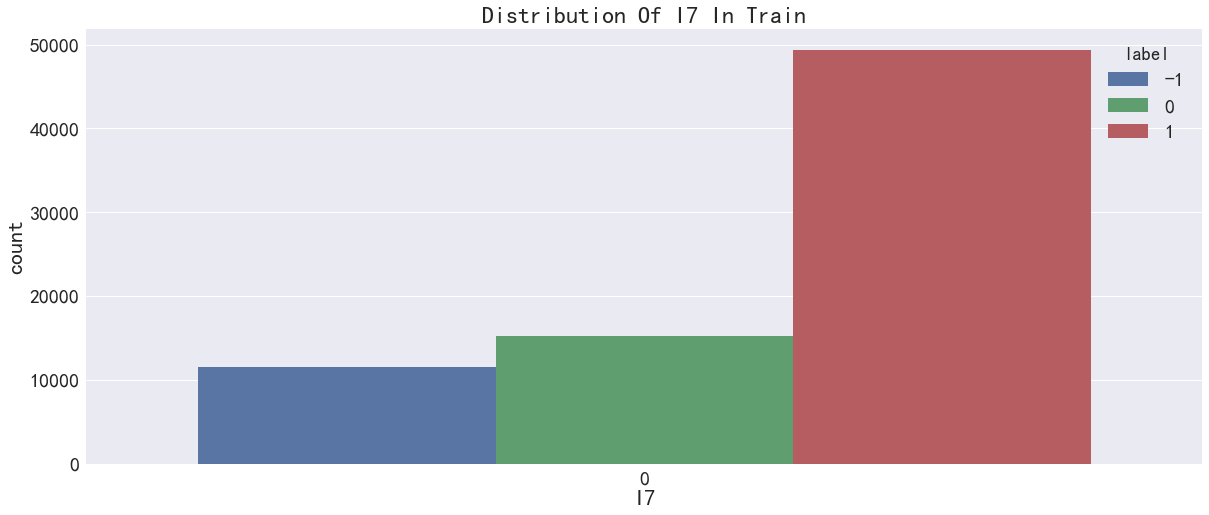

In [138]:
plt.figure(figsize=(20, 8))
plt.subplot(1,1,1)
sns.countplot(x='I7', hue='label', data=train)
plt.title('Distribution Of I7 In Train')
print(train['I7'].value_count())


I8 星座描述

Text(0.5,1,'Distribution Of I8 In Train')

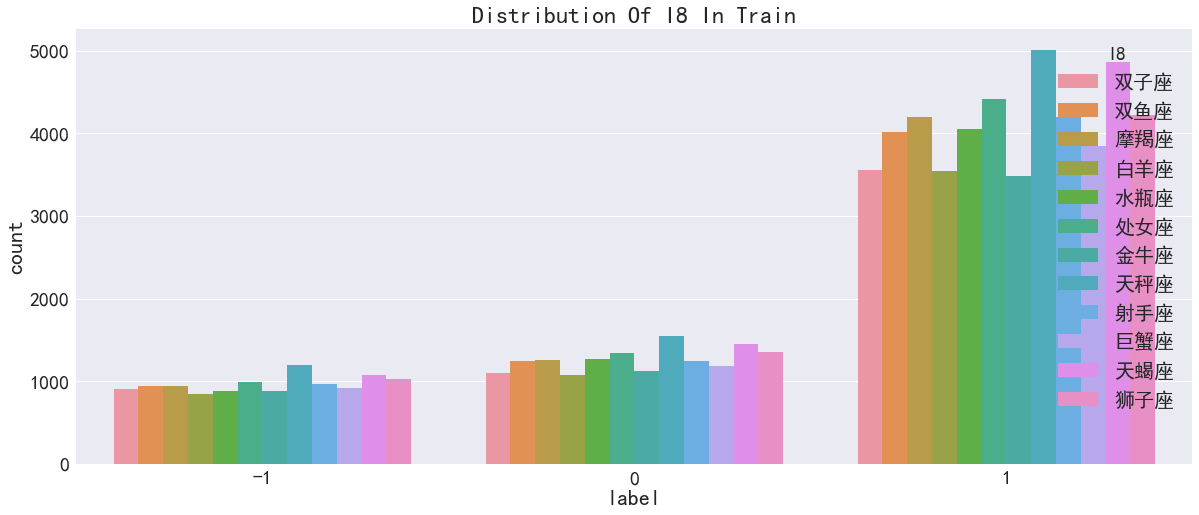

In [139]:
plt.figure(figsize=(20, 8))
plt.subplot(1,1,1)
sns.countplot(x='label', hue='I8', data=train)
plt.title('Distribution Of I8 In Train')


I9 客户贡献度
全为nan

I10 学历描述

Text(0.5,1,'Distribution Of I3 In Train')

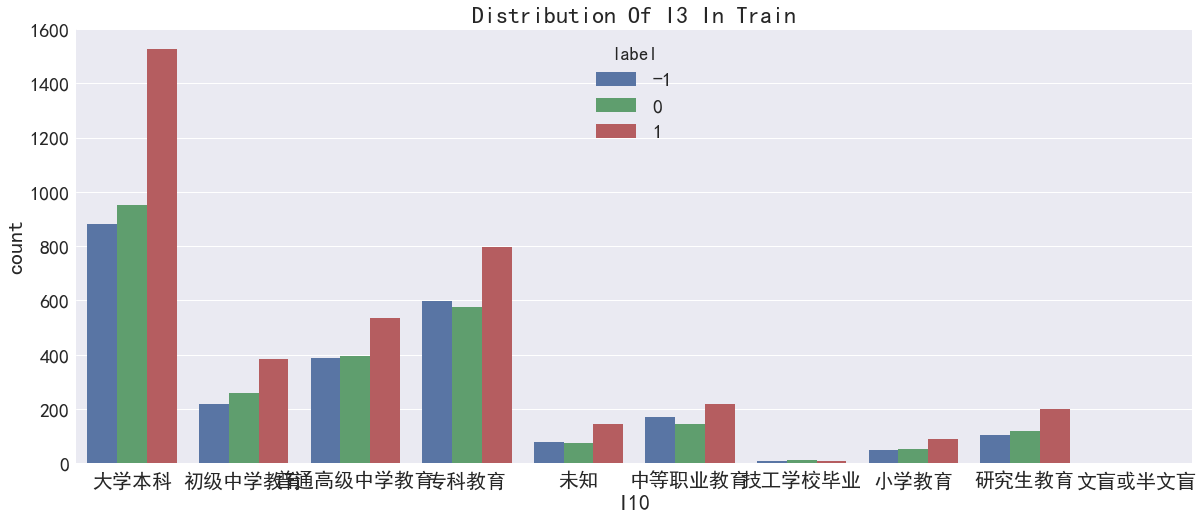

In [157]:
plt.figure(figsize=(20, 8))
plt.subplot(1,1,1)
sns.countplot(x='I10', hue='label', data=train)
plt.title('Distribution Of I10 In Train')


I12 行业描述
只有一个是农业

个人    76169
农业        1
Name: I12, dtype: int64


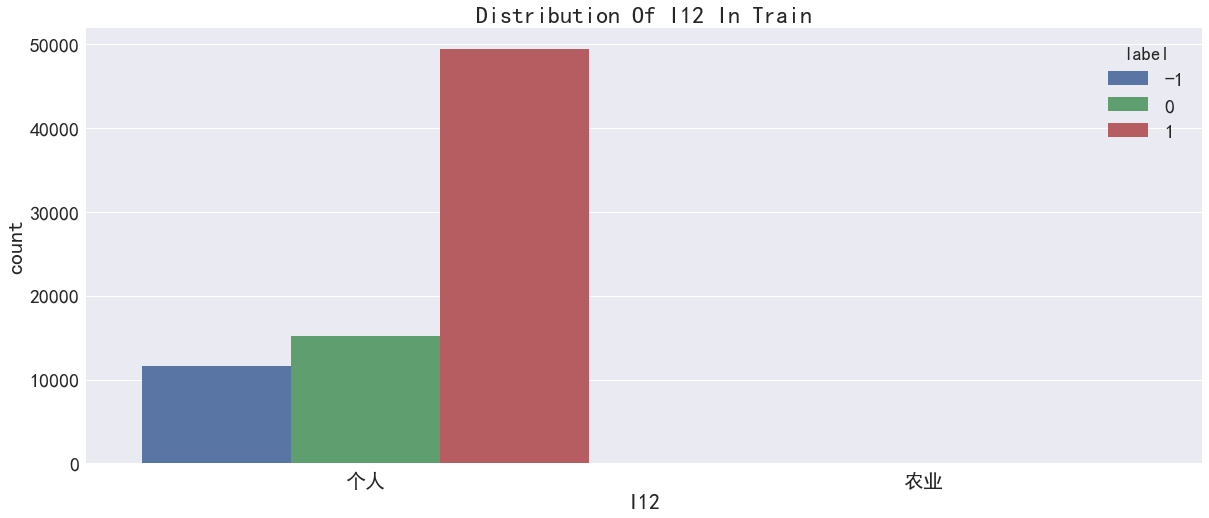

In [144]:
plt.figure(figsize=(20, 8))
plt.subplot(1,1,1)
sns.countplot(x='I12', hue='label', data=train)
plt.title('Distribution Of I12 In Train')
print(train['I12'].value_counts())


I13 婚姻状况描述

Text(0.5,1,'Distribution OfI13In Train')

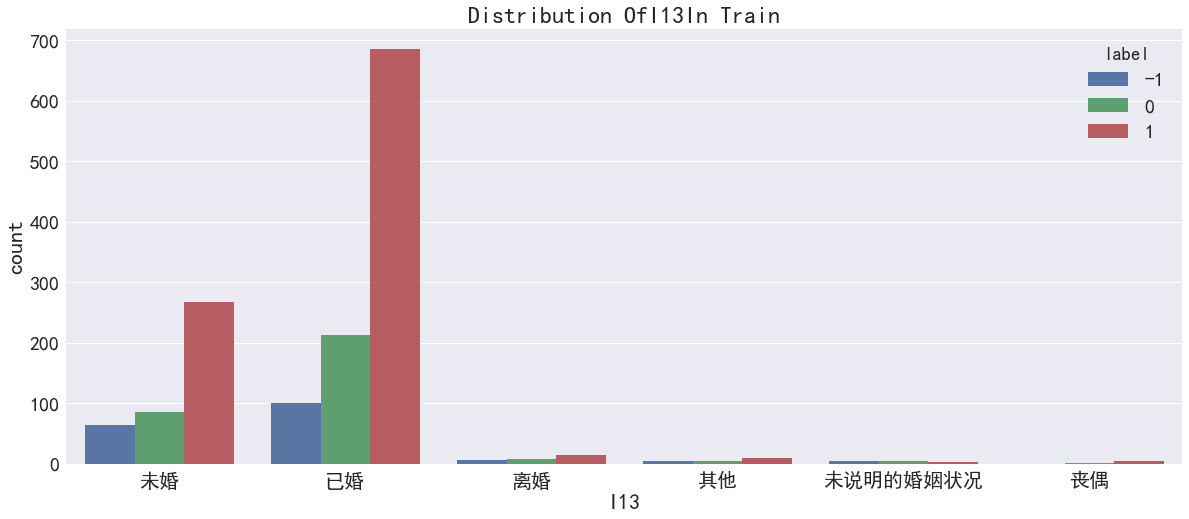

In [145]:
plt.figure(figsize=(20, 8))
plt.subplot(1,1,1)
sns.countplot(x='I13', hue='label', data=train)
plt.title('Distribution Of'+ 'I13'+ 'In Train')


I14 职务描述

Text(0.5,1,'Distribution OfI14In Train')

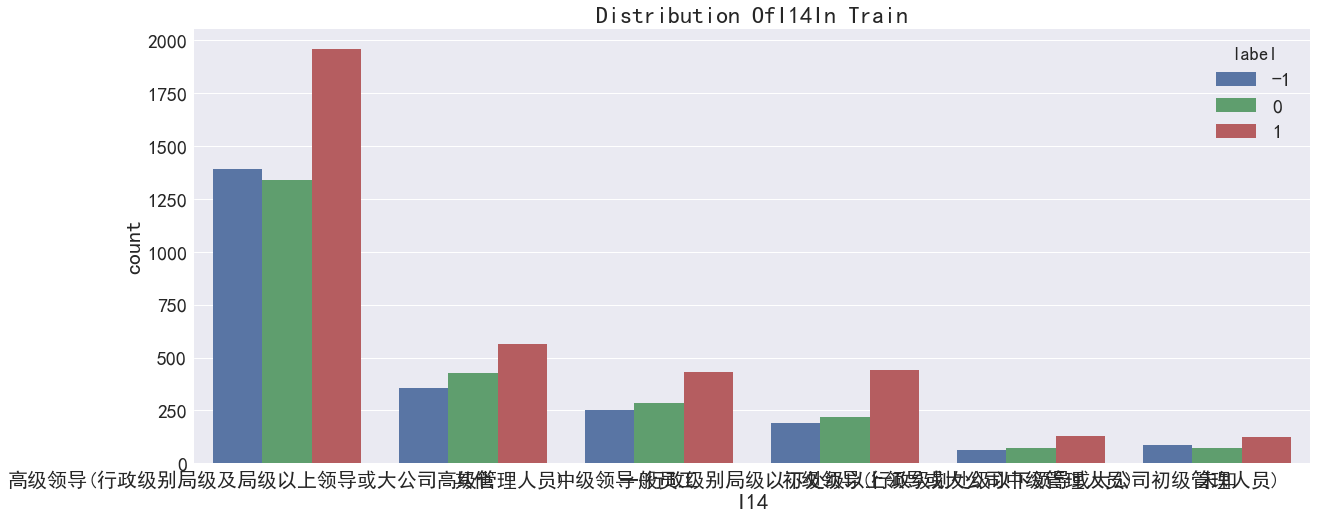

In [155]:
plt.figure(figsize=(20, 8))
plt.subplot(1,1,1)
sns.countplot(x='I14', hue='label', data=train)
plt.title('Distribution Of'+ 'I14'+ 'In Train')


I15 二维码收单客户标志

Text(0.5,1,'Distribution Of I15 In Train')

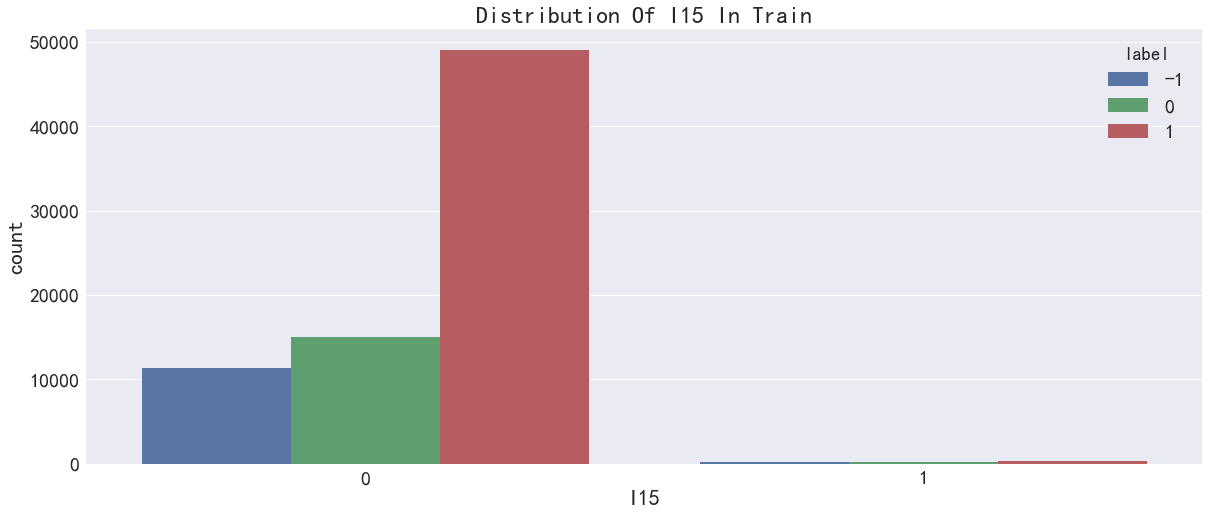

In [146]:
plt.figure(figsize=(20, 8))
plt.subplot(1,1,1)
sns.countplot(x='I15', hue='label', data=train)
plt.title('Distribution Of I15 In Train')

I16 vip客户标志

Text(0.5,1,'Distribution Of I16 In Train')

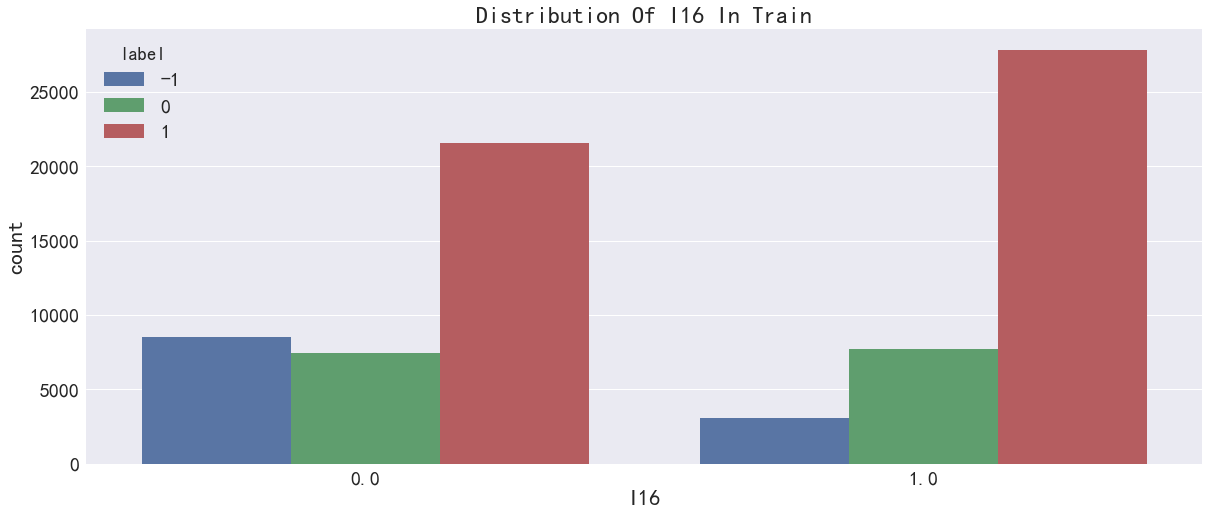

In [147]:
plt.figure(figsize=(20, 8))
plt.subplot(1,1,1)
sns.countplot(x='I16', hue='label', data=train)
plt.title('Distribution Of I16 In Train')


网银客户标志I17和手机银行客户标志I18一样

In [ ]:
(train['I17和']==train['I18']).sum()/len(train)

Text(0.5,1,'Distribution Of I17 In Train')

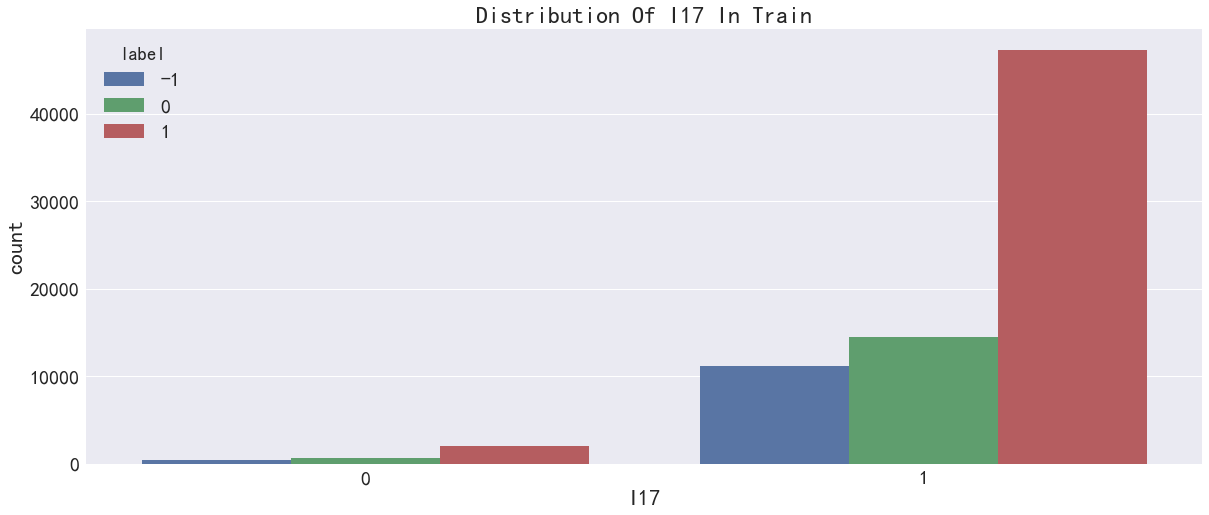

In [156]:
plt.figure(figsize=(20, 8))
plt.subplot(1,1,1)
sns.countplot(x='I17', hue='label', data=train)
plt.title('Distribution Of I17 In Train')


Text(0.5,1,'Distribution Of I18 In Train')

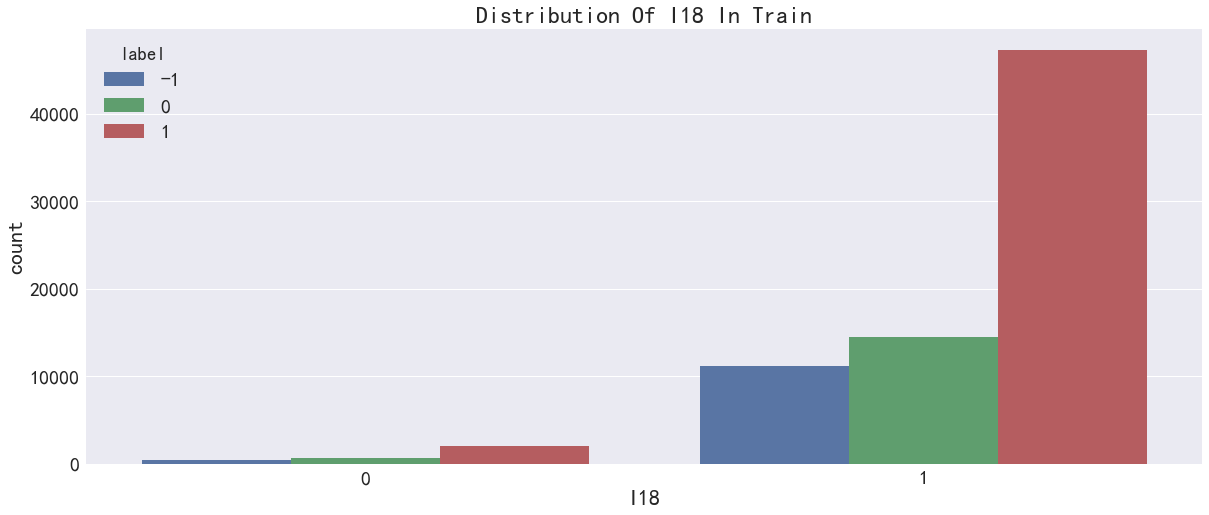

In [149]:
plt.figure(figsize=(20, 8))
plt.subplot(1,1,1)
sns.countplot(x='I18', hue='label', data=train)
plt.title('Distribution Of I18 In Train')


I19短信客户

Text(0.5,1,'Distribution Of I19 In Train')

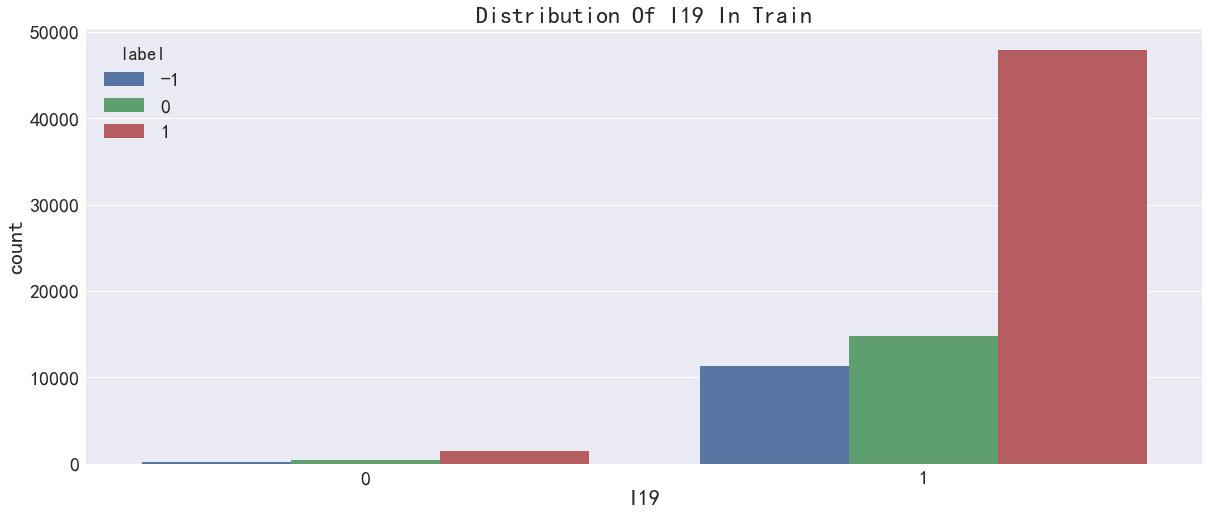

In [150]:
plt.figure(figsize=(20, 8))
plt.subplot(1,1,1)
sns.countplot(x='I19', hue='label', data=train)
plt.title('Distribution Of I19 In Train')


I20 微信支付客户标志

Text(0.5,1,'Distribution Of I20 In Train')

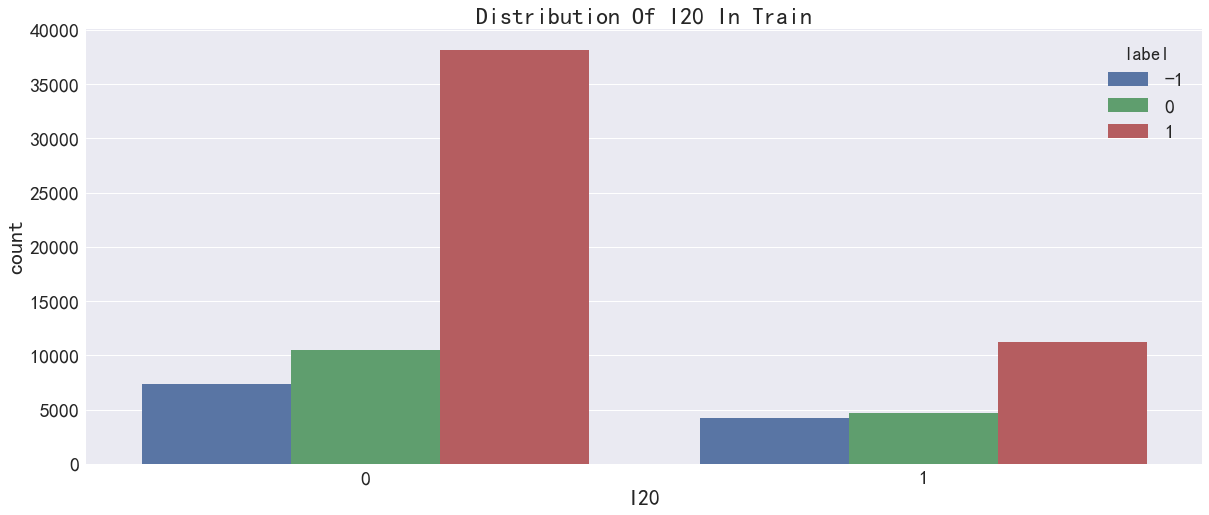

In [151]:
plt.figure(figsize=(20, 8))
plt.subplot(1,1,1)
sns.countplot(x='I20', hue='label', data=train)
plt.title('Distribution Of I20 In Train')


### 训练数据和测试数据分布对比可视化

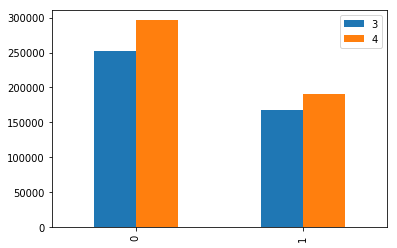

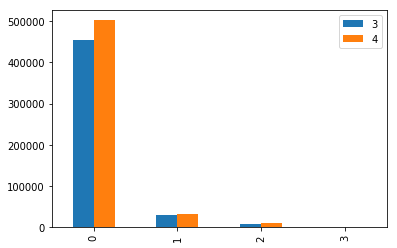

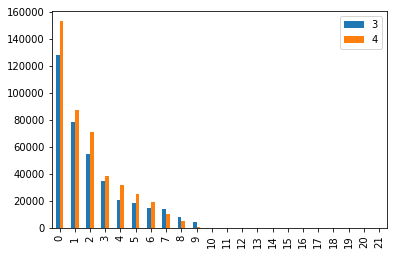

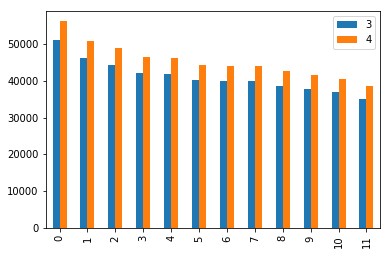

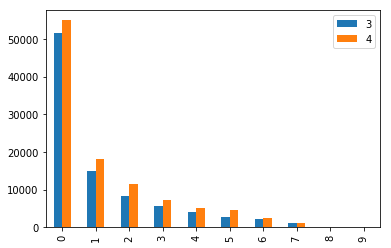

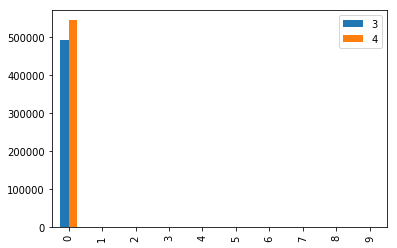

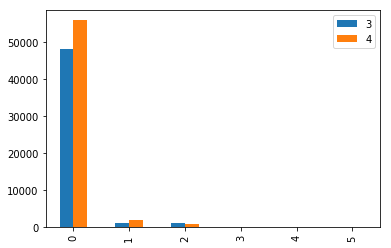

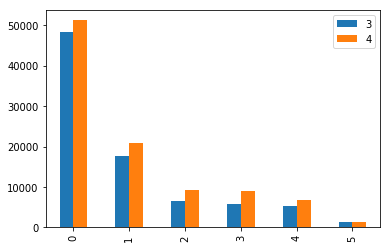

In [92]:
cust_col = [i for i in  cust_info_Q3.select_dtypes('object').columns if i!= 'cust_no'  ]
for col in cust_col:
    df = pd.DataFrame(np.vstack([cust_info_Q3[col].value_counts().values, cust_info_Q4[col].value_counts().values]).T, columns=list('34'))
    # 绘制图形
    df.plot(kind='bar', legend = col)

## 行为数据EDA
  

In [159]:
### 加载数据
behavior_fils = os.listdir('x_train/behavior_train/')+os.listdir('x_test/behavior_test/')
behavior = []
for f in behavior_fils:
    print(f)
    mon = int((f.split('.')[0]).split('_')[-1].replace('m', ''))
    if mon>=7:
        tmp = pd.read_csv('x_train/behavior_train/'+f)
        tmp['mon'] = mon
    else:
        tmp = pd.read_csv('x_test/behavior_test/'+f)
        tmp['mon'] = mon+12
    behavior.append(tmp)
behavior = pd.concat(behavior, axis=0, ignore_index=True)

behavior_m10.csv
behavior_m11.csv
behavior_m12.csv
behavior_m7.csv
behavior_m8.csv
behavior_m9.csv
behavior_m1.csv
behavior_m2.csv
behavior_m3.csv


In [160]:
### 缺失值统计
print(behavior.isnull().sum() / len(behavior))

cust_no    0.000000
B1         0.000000
B2         0.000000
B3         0.000000
B4         0.000000
B5         0.000000
mon        0.000000
B6         0.914564
B7         0.648626
dtype: float64


In [26]:
# def reduce_mem_usage(df, verbose=True):
#     numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
#     start_mem = df.memory_usage().sum() / 1024**2
#     for col in df.columns:
#         col_type = df[col].dtypes
#         if col_type in numerics:
#             c_min = df[col].min()
#             c_max = df[col].max()
#             if str(col_type)[:3] == 'int':
#                 if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
#                     df[col] = df[col].astype(np.int8)
#                 elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
#                     df[col] = df[col].astype(np.int16)
#                 elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
#                     df[col] = df[col].astype(np.int32)
#                 elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
#                     df[col] = df[col].astype(np.int64)
#             else:
#                 c_prec = df[col].apply(lambda x: np.finfo(x).precision).max()
#                 if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max and c_prec == np.finfo(np.float16).precision:
#                     df[col] = df[col].astype(np.float16)
#                 elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max and c_prec == np.finfo(np.float32).precision:
#                     df[col] = df[col].astype(np.float32)
#                 else:
#                     df[col] = df[col].astype(np.float64)
#     end_mem = df.memory_usage().sum() / 1024**2
#     if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
#     return df


# behavior = reduce_mem_usage(behavior)
# behavior.to_csv('behavior.csv', index=False)
behavior = pd.read_csv('behavior.csv')
behavior

,cust_no,B1,B2,B3,B4,B5,mon,B6,B7
0,0xb2d0cb0e,0,0,0.0,0,0.0,10,NaN,NaN
1,0xb2d3c349,0,0,0.0,0,0.0,10,NaN,NaN
2,0xb2d6be98,0,0,0.0,0,0.0,10,NaN,NaN
3,0xb2d44611,0,0,0.0,0,0.0,10,NaN,NaN
4,0xb2d5d95b,0,0,0.0,0,0.0,10,NaN,NaN
...,...,...,...,...,...,...,...,...,...
4829292,0xb2dc4c52,0,0,0.0,0,0.0,15,NaN,0.0
4829293,0xb2dc4c16,0,0,0.0,0,0.0,15,NaN,0.0
4829294,0xb2dc436a,0,0,0.0,0,0.0,15,NaN,0.0
4829295,0xb2dc4928,0,0,0.0,0,0.0,15,NaN,0.0


In [34]:
def get_behavior_fea(x):   
    if x<90:
        return 1  
    elif x<180:
        return 2  
    return 3  
for col in ['B6']:
        behavior[col] = (pd.to_datetime('2020-04-01 00:00:00') - pd.to_datetime(behavior[col])).dt.days
behavior.loc[(behavior['mon']==12), 'B6'] = (behavior.loc[(behavior['mon']==12), 'B6'] - 91).apply(lambda x: get_behavior_fea(x))
behavior.loc[(behavior['mon']==9), 'B6'] = (behavior.loc[(behavior['mon']==9), 'B6']- 183.0).apply(lambda x: get_behavior_fea(x))
behavior.loc[(behavior['mon']==15), 'B6'] = (behavior.loc[(behavior['mon']==15), 'B6']).apply(lambda x: get_behavior_fea(x))


In [31]:
tmp = behavior[behavior['mon']==12].copy()
del tmp['mon']
train = train.merge(tmp, on=['cust_no'], how='left')
tmp = behavior[behavior['mon']==9].copy()
del tmp['mon']
test = test.merge(tmp, on=['cust_no'], how='left')

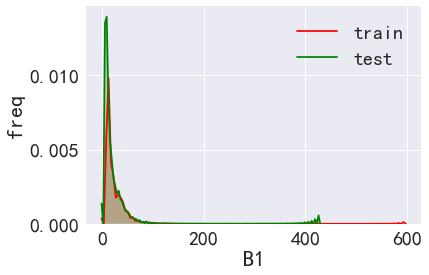

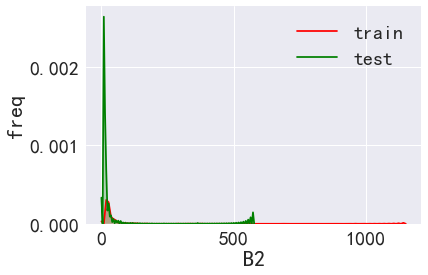

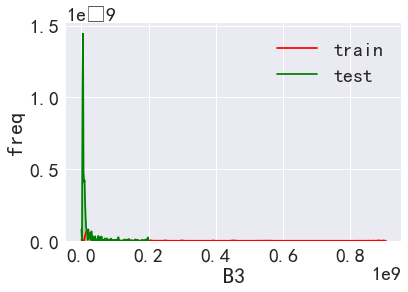

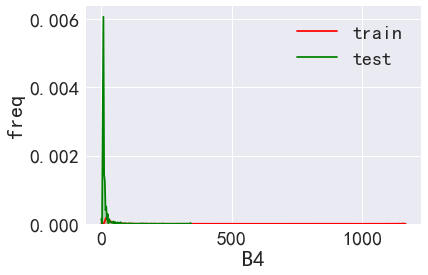

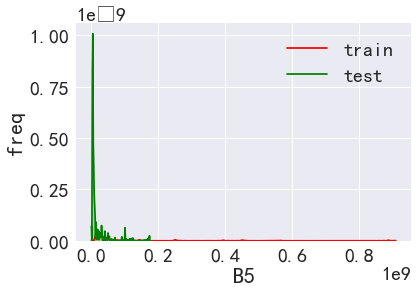

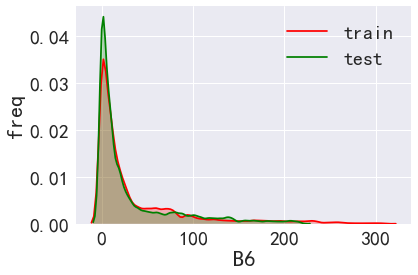

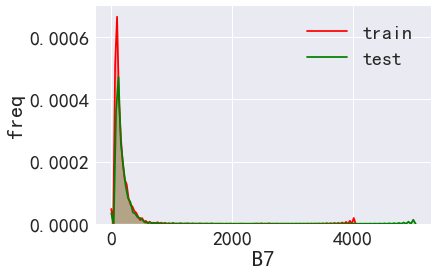

In [32]:
B_cols = [f for f in behavior.columns if f.startswith('B')]
for col in B_cols:
    g = sns.kdeplot(train[col], color="Red", shade = True)
    g = sns.kdeplot(test[col], ax =g, color="Green", shade = True)
    g.set_xlabel(col)
    g.set_ylabel("freq")
    g = g.legend(["train","test"])
    plt.show()
